In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yaml
from tqdm import tqdm

In [2]:
yaml_file= 'params_single_neuron.yaml'

with open(yaml_file, 'r') as f:
    params_single = yaml.safe_load(f)

# Phase plane for LIF and QIF neurons
Run interactive_phase_plane_qif_lif.py to generate the phase plane for LIF and QIF neurons.

# TTS definition

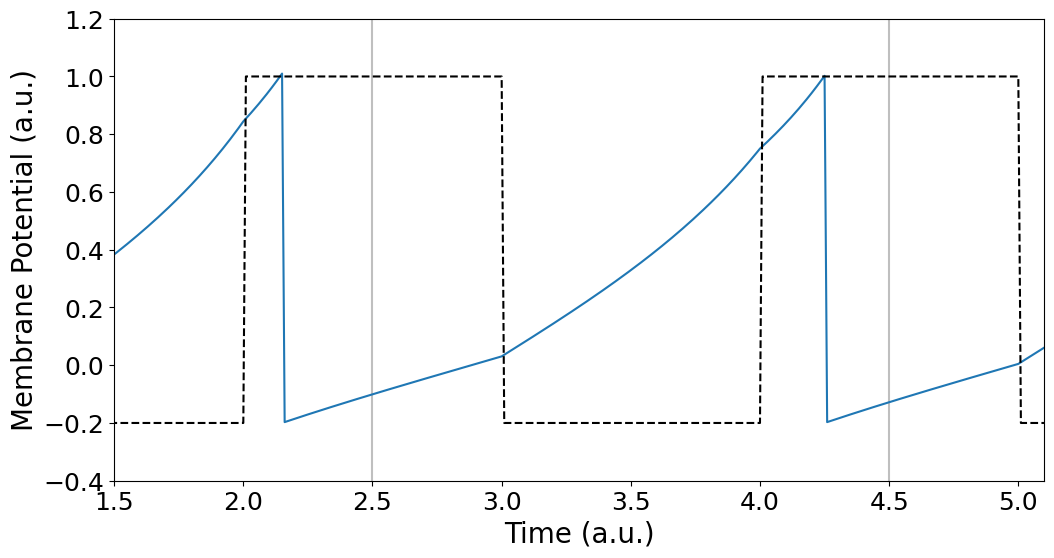

In [ ]:
# Create parameter dictionaries
sim_params = {
    'dt': 0.01,              # Time step (a.u.)
    'sim_time': 5.5,          # Total simulation time (a.u.)
    'v_rest': -0.2,          # Resting potential (a.u.)
    'v_th': 1,               # Threshold potential (a.u.)
    'v_reset': -0.2,         # Reset potential (a.u.)
    'inh_amp': 0.3,       # Amplitude of the input current
    'inh_period': 2      # Period of the input current (a.u.)
}

def simulate_simple_single_neuron(model_type, current, inh_amp=0.25, inh_period=1.6, sim_time=50, dt=0.01,
                                  v_rest=-0.2, v_th=1, v_reset=-0.2):
    """
    Simulates a neuron model (LIF or QIF) with inhibitory input.

    Parameters:
    -----------
    model_type : str
        Type of neuron model ('lif' or 'qif')
    current : float
        Input current magnitude
    inh_amp : float, optional
        Amplitude of inhibitory input
    inh_period : float, optional
        Period of inhibitory input in ms
    sim_time : float, optional
        Total simulation time in ms
    dt : float, optional
        Time step in ms
    v_rest : float, optional
        Resting potential
    v_th : float, optional
        Threshold potential
    v_reset : float, optional
        Reset potential

    Returns:
    --------
    tuple
        (time array, voltage trace, number of spikes)
    """
    # Create time array
    time = np.arange(0, sim_time, dt)

    # Inhibitory input
    inh = inh_amp * (np.sin(2 * np.pi * time / inh_period) > 0).astype(float)

    # Initialize membrane potential
    v = v_rest
    v_trace = np.zeros_like(time)
    num_spikes = 0

    # Simulation loop
    for t in range(len(time)):
        if model_type.lower() == 'lif':
            # LIF neuron update
            dv = (current - v - inh[t]) * dt
        elif model_type.lower() == 'qif':
            # QIF neuron update
            dv = (current + v ** 2 - inh[t]) * dt
        else:
            raise ValueError("model_type must be 'lif' or 'qif'")

        v += dv
        v_trace[t] = v

        if v >= v_th:
            v = v_reset
            num_spikes += 1

    return time, v_trace, num_spikes, inh

# Current parameters for different neuron models
I_qif = 0.56

# Run simulations
time_qif, V_qif_trace, spikes_qif, inh = simulate_simple_single_neuron('qif', I_qif, **sim_params)

rescaled_inh = (inh/sim_params['inh_amp'])*(sim_params['v_th'] - sim_params['v_reset']) + sim_params['v_reset']
inhib_midpoint = sim_params['inh_period'] / 4

# Set plot parameters
font_size = 22
plt.rcParams.update({
    'axes.titlesize': font_size,
    'axes.labelsize': font_size-2 ,
    'xtick.labelsize': font_size-4,
    'ytick.labelsize': font_size-4,
    'legend.fontsize': font_size-4
})

# Add vertical lines at inhibition mid-points
plt.figure(figsize=(12, 6))
for t in np.arange(inhib_midpoint, sim_params['sim_time'], sim_params['inh_period']):
    plt.axvline(x=t, color='gray', linestyle='-', alpha=0.5)

plt.plot(time_qif, V_qif_trace)
plt.plot(time_qif, rescaled_inh, 'k--')
plt.xlabel('Time (a.u.)')
plt.ylabel('Membrane Potential (a.u.)')
plt.ylim(-0.4, 1.2)
plt.xlim([1.5, 5.1])
plt.show()

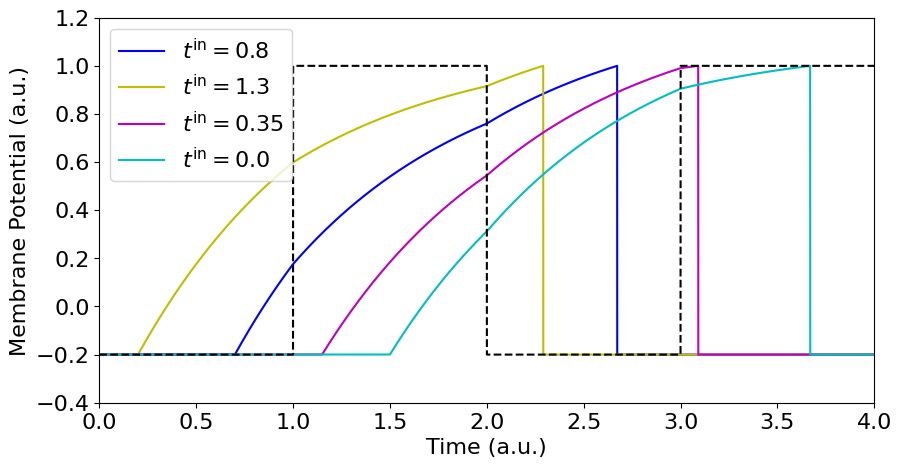

In [7]:
def simulate_neuron_tin(ax, tin_array, I, inh_amp, inh_period, dt=0.0001, V_th=1, V_reset=0):
    """
    Simulate LIF neuron with varying input times (tin_array).

    Parameters:
    -----------
    ax : matplotlib axis
        Axis to plot the results.
    tin_array : ndarray
        Array of input times for each neuron.
    I : float
        Input current.
    inh_amp : float
        Amplitude of inhibition.
    inh_period : float
        Period of inhibition.
    dt : float
        Time step (a.u.).
    V_th : float
        Threshold potential (a.u.).
    V_reset : float
        Reset potential (a.u.).
    tau : float
        Membrane time constant (a.u.).

    Returns:
    --------
    tts : ndarray
        Time-to-spike for each neuron.
    """
    T = inh_period * 2
    start_time_array = inh_period * 0.75 - tin_array
    time = np.arange(0, T, dt)
    inh = inh_amp * (-np.cos(2 * np.pi * time / inh_period - np.pi / 2) > 0).astype(float)
    V_lif = V_reset * np.ones(len(tin_array))
    V_lif_trace = np.zeros((len(time), len(tin_array)))
    active_neurons = np.ones(len(tin_array), dtype=bool)  # Track active neurons
    spike_times = np.full(len(tin_array), np.nan)  # Initialize spike times with NaN

    for t in range(len(time)):
        dV_lif = ((-V_lif + I - inh[t])) * dt
        V_lif += dV_lif * (time[t] >= start_time_array) * active_neurons
        V_lif_trace[t] = V_lif
        # Record spike time for neurons that reach V_th
        spiking_neurons = (V_lif >= V_th) & active_neurons
        spike_times[spiking_neurons] = time[t]
        # Reset voltage for neurons that spike
        V_lif[spiking_neurons] = V_reset
        # Stop updating voltages for neurons that have spiked
        active_neurons &= ~spiking_neurons

    rescaled_inh = (inh / inh_amp) * (V_th - V_reset) + V_reset
    ax.clear()
    colour_list = ['b','y','m', 'c']
    for i in range(len(tin_array)):
        ax.plot(time, V_lif_trace[:, i], colour_list[i],label=rf"$t^{{\mathrm{{in}}}}={tin_array[i]}$",)
    ax.plot(time, rescaled_inh, 'k--')
    ax.set_xlabel("Time (a.u.)")
    ax.set_ylabel("Membrane Potential (a.u.)")
    ax.set_ylim([V_reset - 0.2, V_th + 0.2])
    ax.set_xlim([0, T])
    ax.legend(loc='upper left')

    tts = spike_times - start_time_array

    return tts


params_lif = params_single['lif_model']['preset2']

import inspect


# Get the argument names of the function
arg_names = inspect.signature(simulate_neuron_tin).parameters.keys()

# Filter params_lif to include only keys that match the function's arguments
filtered_params_lif = {key: value for key, value in params_lif.items() if key in arg_names}

font_size = 20
plt.rcParams.update({
    'axes.titlesize': font_size,
    'axes.labelsize': font_size-4,
    'xtick.labelsize': font_size-4,
    'ytick.labelsize': font_size-4,
    'legend.fontsize': font_size-4
})

fig, ax = plt.subplots(figsize=(10, 5))
tin_array = np.array([0.8, 1.3, 0.35, 0])
inh_period = 2
tts = simulate_neuron_tin(ax, tin_array, **filtered_params_lif)
new_tin = (tin_array + inh_period - tts)

# TTS and fixed point
Run interactive_tts.py to generate the TTS and see the fixed point for LIF and QIF neurons.

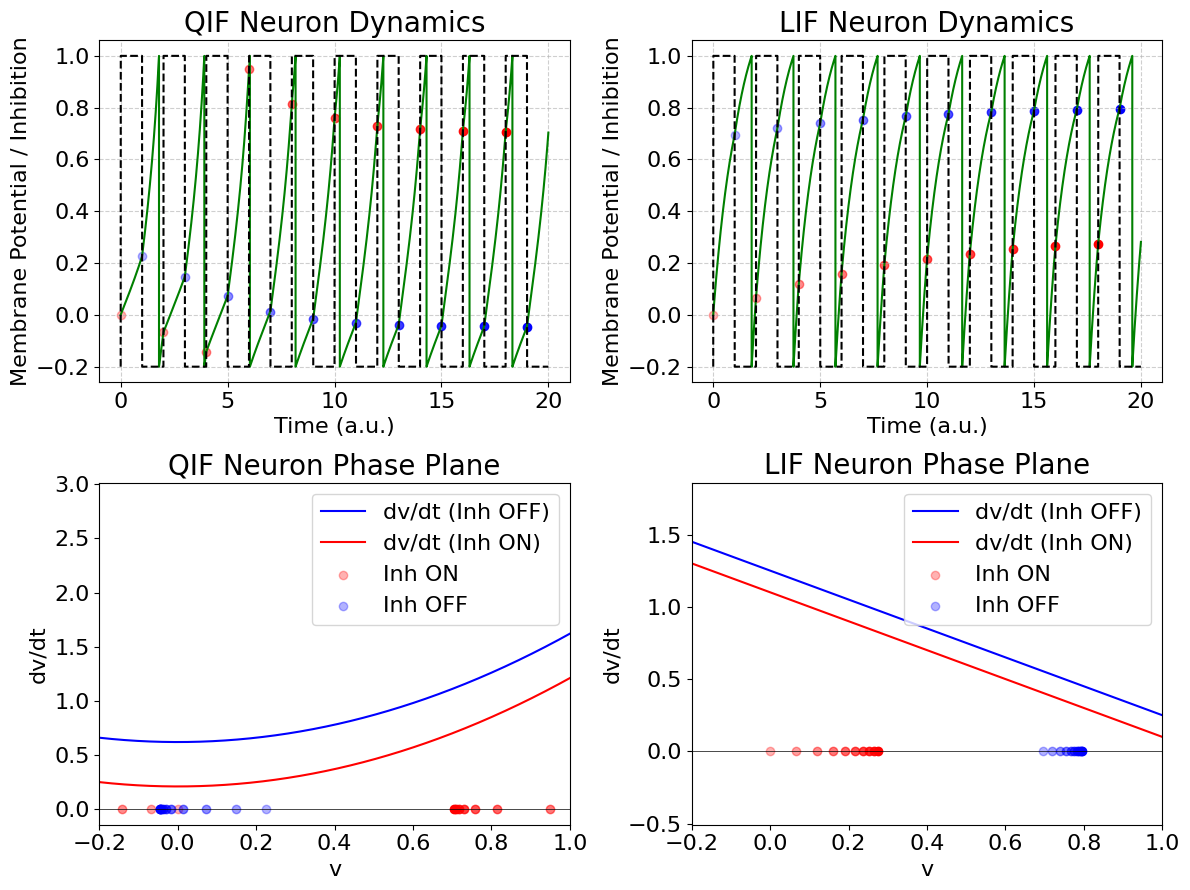

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from neuron_simulation_utils import simulate_simple_single_neuron
import yaml

yaml_file='/Users/tsekanap/PycharmProjects/phase_tts/params_single_neuron.yaml'

with open(yaml_file, 'r') as f:
    params = yaml.safe_load(f)

def neuron_phase_plane(model="LIF", ax_phase=None, ax_time=None, I=1.4, inh_amp=0.25, mid_point=0.0,
                       v_rest=0.0, V_th=1.0, V_reset=-0.2, dt=0.01, T=20, inh_period=1.6):
    """
    Plot phase plane and time series for LIF or QIF neuron.

    Parameters:
        model (str): "LIF" or "QIF" to select the neuron model.
        ax_phase, ax_time: Axes for phase plane and time series plots.
        Other parameters: Neuron and simulation parameters.
    """
    time = np.arange(0, T, dt)
    inh = inh_amp * (np.sin(2 * np.pi * time / inh_period) > 0).astype(float)
    v_trace = np.zeros_like(time)
    v_trace[0] = v_rest if model == "LIF" else 0

    # Simulate the neuron
    for t in range(1, len(time)):
        if model == "LIF":
            v_dot = -(v_trace[t-1] - v_rest) + I - inh[t-1]
        elif model == "QIF":
            v_dot = I + (v_trace[t-1] - mid_point)**2 - inh[t-1]
        else:
            raise ValueError("Model must be 'LIF' or 'QIF'")
        v_trace[t] = v_trace[t-1] + v_dot * dt
        if v_trace[t] >= V_th:
            v_trace[t] = V_reset

    # Detect transitions in inhibition
    inh_diff = np.diff(inh)
    inh_on_indices = np.where(inh_diff > 0)[0]
    inh_off_indices = np.where(inh_diff < 0)[0]
    alphas_on = np.linspace(0.3, 1, len(inh_on_indices))
    alphas_off = np.linspace(0.3, 1, len(inh_off_indices))

    # Phase plane dynamics
    v = np.linspace(-0.5, 1.5, 1000)
    if model == "LIF":
        v_dot_inh_off = -(v - v_rest)  + I
        v_dot_inh_on = -(v - v_rest)  + I - inh_amp
    elif model == "QIF":
        v_dot_inh_off = I + (v - mid_point)**2
        v_dot_inh_on = I + (v - mid_point)**2 - inh_amp
    else:
        raise ValueError("Model must be 'LIF' or 'QIF'")

    # Plot phase plane
    if ax_phase is None:
        fig, ax_phase = plt.subplots(figsize=(6, 4))
    ax_phase.plot(v, np.zeros_like(v), 'k-', lw=0.5)  # Nullcline
    ax_phase.plot(v, v_dot_inh_off, 'b-', label='dv/dt (Inh OFF)')
    ax_phase.plot(v, v_dot_inh_on, 'r-', label='dv/dt (Inh ON)')
    for i, idx in enumerate(inh_on_indices):
        ax_phase.scatter(v_trace[idx], 0, color='r', alpha=alphas_on[i], label='Inh ON' if i == 0 else "")
    for i, idx in enumerate(inh_off_indices):
        ax_phase.scatter(v_trace[idx], 0, color='b', alpha=alphas_off[i], label='Inh OFF' if i == 0 else "")
    ax_phase.set_xlabel('v')
    ax_phase.set_ylabel('dv/dt')
    ax_phase.set_title(f'{model} Neuron Phase Plane')
    ax_phase.legend(loc='upper right')
    # ax_phase.grid(True, linestyle='--', alpha=0.6)
    ax_phase.set_xlim([V_reset, V_th])

    # Plot time series
    if ax_time is None:
        fig, ax_time = plt.subplots(figsize=(6, 4))
    ax_time.plot(time, v_trace, 'g-', label='Membrane Potential')
    ax_time.plot(time, inh * (V_th - V_reset) / inh_amp + V_reset, 'k--', label='Inhibition')
    for i, idx in enumerate(inh_on_indices):
        ax_time.scatter(time[idx], v_trace[idx], color='r', alpha=alphas_on[i], label='Inh ON' if i == 0 else "")
    for i, idx in enumerate(inh_off_indices):
        ax_time.scatter(time[idx], v_trace[idx], color='b', alpha=alphas_off[i], label='Inh OFF' if i == 0 else "")
    ax_time.set_xlabel('Time (a.u.)')
    ax_time.set_ylabel('Membrane Potential / Inhibition')
    ax_time.set_title(f'{model} Neuron Dynamics')
    # ax_time.legend(loc='upper right')
    ax_time.grid(True, linestyle='--', alpha=0.6)

# Plot LIF and QIF side by side
qif_params1 = params['qif_model']['preset2']
lif_params1 = params['lif_model']['preset2']

# Plot LIF and QIF side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
neuron_phase_plane(ax_time=axs[0, 0], ax_phase=axs[1, 0], **qif_params1)
neuron_phase_plane(ax_time=axs[0, 1], ax_phase=axs[1, 1], **lif_params1)
plt.tight_layout()
plt.show()

## Heat maps for fixed point and parameters

In [3]:
def compute_tts_lif(I, inh_amp, inh_period, V_th=1, V_reset=0, dt=0.001, T=10, n_grid=200):
    time = np.arange(0, T, dt)
    center_array = np.linspace(0, inh_period, n_grid)
    V_lif = V_reset * np.ones(n_grid)
    V_lif_trace = np.zeros((len(time), n_grid))
    for t_idx, t in enumerate(time):
        inh = inh_amp * (np.sin(2 * np.pi * (t - center_array) / inh_period + np.pi / 2) > 0)
        dV_lif = (I - V_lif - inh) * dt
        V_lif += dV_lif
        V_lif_trace[t_idx, :] = V_lif
    crossed = V_lif_trace > V_th
    first_cross = np.argmax(crossed, axis=0)
    tts_array = np.where(np.any(crossed, axis=0), time[first_cross], np.nan)
    return center_array, tts_array

def manual_fixed_point_lif(I, inh_amp, inh_period, V_th=1, V_reset=0, dt=0.001, T=10, n_grid=200):
    center_array, tts_array = compute_tts_lif(I, inh_amp, inh_period, V_th, V_reset, dt, T, n_grid)
    diff_array = tts_array - inh_period
    if np.any(np.abs(diff_array) > 5):
        return np.nan
    cross_idx = np.where((diff_array[:-1] < 0) & (diff_array[1:] >= 0))[0]
    if len(cross_idx) > 0:
        idx = cross_idx[0]
        return center_array[idx]
    else:
        return np.nan

# Load base parameters
yaml_file = 'params_single_neuron.yaml'
with open(yaml_file, 'r') as f:
    params = yaml.safe_load(f)['lif_model']['preset2']
inh_period = params['inh_period']
V_th = params.get('V_th', 1)
V_reset = params.get('V_reset', 0)

# Parameter ranges
inh_amp_values_lif = np.linspace(0.1, 1.25, 30)
I_values_lif = np.linspace(1.2, 1.5, 30)
fixed_points_lif = np.full((len(I_values_lif), len(inh_amp_values_lif)), np.nan)

for i, I in enumerate(tqdm(I_values_lif)):
    for j, inh_amp in enumerate(inh_amp_values_lif):
        t_ss = manual_fixed_point_lif(I, inh_amp, inh_period, V_th, V_reset)
        fixed_points_lif[i, j] = t_ss


100%|██████████| 30/30 [00:39<00:00,  1.33s/it]


In [4]:
# Recompute LIF fixed points with V_reset=0 for theoretical comparison
V_th_new = 1  # Keep same
V_reset_new = 0  # Change from -0.2 to 0

fixed_points_lif_v0 = np.full((len(I_values_lif), len(inh_amp_values_lif)), np.nan)

for i, I in enumerate(tqdm(I_values_lif)):
    for j, inh_amp in enumerate(inh_amp_values_lif):
        t_ss = manual_fixed_point_lif(I, inh_amp, inh_period, V_th_new, V_reset_new)
        fixed_points_lif_v0[i, j] = t_ss

100%|██████████| 30/30 [00:40<00:00,  1.35s/it]


In [11]:
def compute_tts_qif(I, inh_amp, inh_period, V_th=1, V_reset=0, dt=0.001, T=10, n_grid=200):
    time = np.arange(0, T, dt)
    center_array = np.linspace(0, inh_period, n_grid)
    V_qif = V_reset * np.ones(n_grid)
    V_qif_trace = np.zeros((len(time), n_grid))
    for t_idx, t in enumerate(time):
        inh = inh_amp * (np.sin(2 * np.pi * (t - center_array) / inh_period + np.pi / 2) > 0)
        dV_qif = (I + V_qif**2 - inh) * dt
        V_qif += dV_qif
        V_qif_trace[t_idx, :] = V_qif
    # Find first crossing of threshold for each center
    crossed = V_qif_trace > V_th
    first_cross = np.argmax(crossed, axis=0)
    # If never crossed, set to nan
    tts_array = np.where(np.any(crossed, axis=0), time[first_cross], np.nan)
    return center_array, tts_array

def compute_fixed_point_qif(I, inh_amp, inh_period, V_th=1, V_reset=0, dt=0.001, T=10, n_grid=200):
    center_array, tts_array = compute_tts_qif(I, inh_amp, inh_period, V_th, V_reset, dt, T, n_grid)
    diff_array = tts_array - inh_period
    if np.any(np.abs(diff_array) > 5):
        return np.nan
    cross_idx = np.where((diff_array[:-1] < 0) & (diff_array[1:] >= 0))[0]
    if len(cross_idx) > 0:
        idx = cross_idx[0]
        fixed_point = center_array[idx]
        if fixed_point > inh_period / 2:
            fixed_point -= inh_period
        return fixed_point
    elif diff_array[0] > 0 and diff_array[-1] < 0:
        return 0
    else:
        return np.nan

# Load base parameters
yaml_file = 'params_single_neuron.yaml'
with open(yaml_file, 'r') as f:
    params = yaml.safe_load(f)['qif_model']['preset2']
inh_period = params['inh_period']
V_th = params.get('V_th', 1)
V_reset = params.get('V_reset', 0)

# Parameter ranges
inh_amp_values_qif = np.linspace(0.15, 0.85, 30)
I_values_qif = np.linspace(0.5, 0.9, 30)
fixed_points_qif = np.full((len(I_values_qif), len(inh_amp_values_qif)), np.nan)

for i, I in enumerate(tqdm(I_values_qif)):
    for j, inh_amp in enumerate(inh_amp_values_qif):
        t_ss = compute_fixed_point_qif(I, inh_amp, inh_period, V_th, V_reset)
        fixed_points_qif[i, j] = t_ss

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/7b/w6s78fxj0m54_hf95yll_gn00000gn/T/ipykernel_10127/4028896475.py:8: RuntimeWarning: overflow encountered in square
  dV_qif = (I + V_qif**2 - inh) * dt
100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


/var/folders/7b/w6s78fxj0m54_hf95yll_gn00000gn/T/ipykernel_10127/4065813335.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


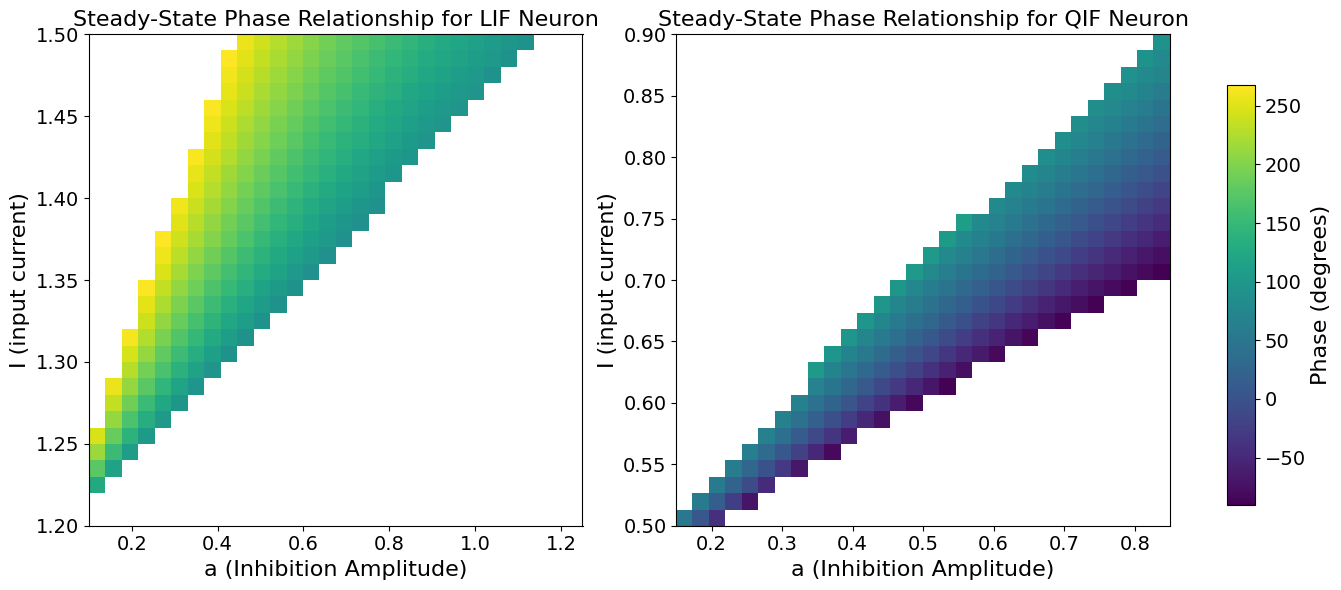

In [12]:
# Convert to degrees
fixed_points_phase_lif = fixed_points_lif / inh_period * 360
fixed_points_phase_qif = fixed_points_qif / inh_period * 360

# Create a figure with subplots and space for colorbar
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

fontsize = 16  # Adjust as needed

# Common vmin and vmax for consistent color mapping
vmin = min(np.nanmin(fixed_points_phase_lif), np.nanmin(fixed_points_phase_qif))
vmax = max(np.nanmax(fixed_points_phase_lif), np.nanmax(fixed_points_phase_qif))

# LIF subplot
im1 = axs[0].imshow(fixed_points_phase_lif, aspect='auto', origin='lower',
                   extent=(inh_amp_values_lif[0], inh_amp_values_lif[-1], I_values_lif[0], I_values_lif[-1]),
                   cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_xlabel('a (Inhibition Amplitude)', fontsize=fontsize)
axs[0].set_ylabel('I (input current)', fontsize=fontsize)
axs[0].set_title('Steady-State Phase Relationship for LIF Neuron', fontsize=fontsize)
axs[0].tick_params(axis='both', labelsize=fontsize-2)

# QIF subplot
im2 = axs[1].imshow(fixed_points_phase_qif, aspect='auto', origin='lower',
                   extent=(inh_amp_values_qif[0], inh_amp_values_qif[-1], I_values_qif[0], I_values_qif[-1]),
                   cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_xlabel('a (Inhibition Amplitude)', fontsize=fontsize)
axs[1].set_ylabel('I (input current)', fontsize=fontsize)
axs[1].set_title('Steady-State Phase Relationship for QIF Neuron', fontsize=fontsize)
axs[1].tick_params(axis='both', labelsize=fontsize-2)

# Set axis limits to match heatmap boundaries
axs[0].set_xlim(inh_amp_values_lif[0], inh_amp_values_lif[-1])
axs[0].set_ylim(I_values_lif[0], I_values_lif[-1])

# For the QIF subplot
axs[1].set_xlim(inh_amp_values_qif[0], inh_amp_values_qif[-1])
axs[1].set_ylim(I_values_qif[0], I_values_qif[-1])

# Add a single colorbar to the right of both subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax, label='Phase (degrees)')
cbar.ax.tick_params(labelsize=fontsize-2)
cbar.set_label('Phase (degrees)', fontsize=fontsize)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Computing QIF boundary lines...


100%|██████████| 200/200 [00:00<00:00, 4876.13it/s]
/var/folders/7b/w6s78fxj0m54_hf95yll_gn00000gn/T/ipykernel_10127/3052358625.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


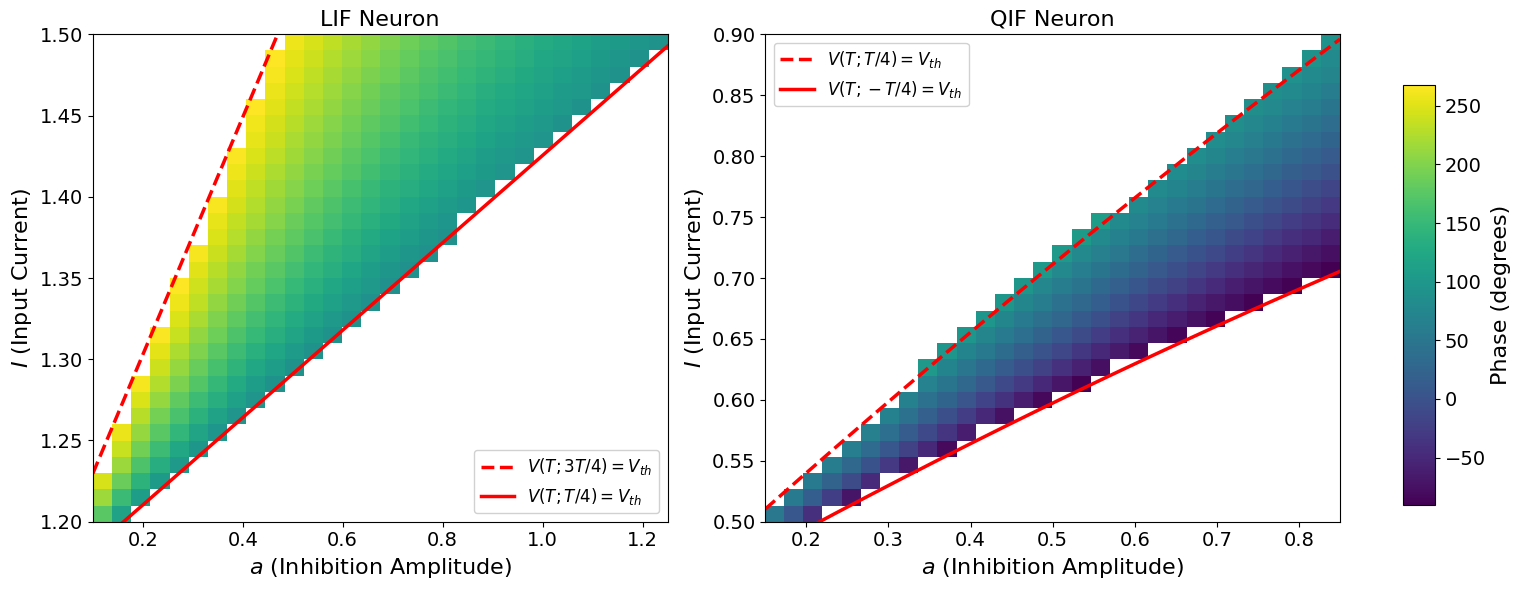

In [19]:
# New heatmap with theoretical boundary lines
# %matplotlib widget
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Convert to degrees for LIF with V_reset=0
fixed_points_phase_lif_v0 = fixed_points_lif_v0 / inh_period * 360
fixed_points_phase_qif_copy = fixed_points_qif / inh_period * 360

# LIF Theoretical Boundaries
T = inh_period  # Period from params
a_vals_lif = np.linspace(inh_amp_values_lif[0], inh_amp_values_lif[-1], 200)

# Boundary 1: I(1-e^-T) - a(1-e^(-T/2)) = 1
I_boundary1_lif = (1 + a_vals_lif * (1 - np.exp(-T/2))) / (1 - np.exp(-T))

# Boundary 2: I(1-e^-T) - a(1-e^(-T/2))e^(-T/2) = 1
I_boundary2_lif = (1 + a_vals_lif * (1 - np.exp(-T/2)) * np.exp(-T/2)) / (1 - np.exp(-T))

# QIF Theoretical Boundaries (Equations 17 and 18)
# For I > a case
def V_eq17_I_gt_a(I, a, T, V_r=-0.2):
    """Calculate V(T, T/4) for QIF neuron when I > a (Equation 17)."""
    if I <= 0 or a < 0:
        return np.nan
    try:
        term1 = np.sqrt(I - a) * np.tan(np.sqrt(I - a) * T / 2 + np.arctan(V_r / np.sqrt(I - a)))
        inner = term1 / np.sqrt(I)
        outer = np.sqrt(I) * T / 2 + np.arctan(inner)
        return np.sqrt(I) * np.tan(outer)
    except:
        return np.nan

def V_eq18_I_gt_a(I, a, T, V_r=-0.2):
    """Calculate V(T, -T/4) for QIF neuron when I > a (Equation 18)."""
    if I <= 0 or a < 0:
        return np.nan
    try:
        term1 = np.sqrt(I) * np.tan(np.sqrt(I) * T / 2 + np.arctan(V_r / np.sqrt(I)))
        inner = term1 / np.sqrt(I - a)
        outer = np.sqrt(I - a) * T / 2 + np.arctan(inner)
        return np.sqrt(I - a) * np.tan(outer)
    except:
        return np.nan

# For a > I case (from new screenshots)
def V_eq17_a_gt_I(I, a, T, V_r=-0.2):
    """Calculate V(T, T/4) for QIF neuron when a > I > 0."""
    if I <= 0 or a <= 0:
        return np.nan
    try:
        # arcoth( V_r / sqrt(a-I) )
        x = V_r / np.sqrt(a - I)
        if np.abs(x) <= 1:
            return np.nan

        arcoth_term = 0.5 * np.log((x + 1) / (x - 1))

        # V(T/2) = sqrt(a-I) * coth( arcoth(...) - sqrt(a-I)*T/2 )
        y = arcoth_term - np.sqrt(a - I) * T / 2
        V_T2 = np.sqrt(a - I) / np.tanh(y)

        # V(T; T/4) = sqrt(I) * tan( sqrt(I)*T/2 + atan( V(T/2)/sqrt(I) ) )
        return np.sqrt(I) * np.tan(np.sqrt(I) * T / 2 + np.arctan(V_T2 / np.sqrt(I)))
    except:
        return np.nan


def V_eq18_a_gt_I(I, a, T, V_r=-0.2):
    """Calculate V(T, -T/4) for QIF neuron when a > I > 0."""
    if I <= 0 or a <= 0:
        return np.nan
    try:
        # V(T/2) during the excitatory half (input = I > 0)
        V_T2 = np.sqrt(I) * np.tan(np.sqrt(I) * T / 2 + np.arctan(V_r / np.sqrt(I)))

        # arcoth( V(T/2) / sqrt(a-I) )
        x = V_T2 / np.sqrt(a - I)
        if np.abs(x) <= 1:
            return np.nan

        arcoth_term = 0.5 * np.log((x + 1) / (x - 1))

        # V(T; -T/4) = sqrt(a-I) * coth( arcoth(...) - sqrt(a-I) * T/2 )
        y = arcoth_term - np.sqrt(a - I) * T / 2
        return np.sqrt(a - I) / np.tanh(y)
    except:
        return np.nan



# Unified functions that handle both cases
def V_eq17(I, a, T, V_r=-0.2):
    """Calculate V(T, T/4) for QIF neuron (handles both I>a and a>I)."""
    if I > a:
        return V_eq17_I_gt_a(I, a, T, V_r)
    else:
        return V_eq17_a_gt_I(I, a, T, V_r)

def V_eq18(I, a, T, V_r=-0.2):
    """Calculate V(T, -T/4) for QIF neuron (handles both I>a and a>I)."""
    if I > a:
        return V_eq18_I_gt_a(I, a, T, V_r)
    else:
        return V_eq18_a_gt_I(I, a, T, V_r)

# Compute QIF boundaries numerically
a_vals_qif = np.linspace(inh_amp_values_qif[0], inh_amp_values_qif[-1], 200)
I_boundary17_qif = []
I_boundary18_qif = []

print("Computing QIF boundary lines...")
for a in tqdm(a_vals_qif):
    # Equation 17
    try:
        I_sol = fsolve(lambda I: V_eq17(I, a, T) - V_th, x0=a+0.1, full_output=True)
        if I_sol[2] == 1 and I_sol[0][0] > 0:  # Converged and valid
            I_boundary17_qif.append(I_sol[0][0])
        else:
            I_boundary17_qif.append(np.nan)
    except:
        I_boundary17_qif.append(np.nan)
    
    # Equation 18
    try:
        I_sol = fsolve(lambda I: V_eq18(I, a, T) - V_th, x0=a+0.1, full_output=True)
        if I_sol[2] == 1 and I_sol[0][0] > 0:  # Converged and valid
            I_boundary18_qif.append(I_sol[0][0])
        else:
            I_boundary18_qif.append(np.nan)
    except:
        I_boundary18_qif.append(np.nan)

I_boundary17_qif = np.array(I_boundary17_qif)
I_boundary18_qif = np.array(I_boundary18_qif)

# Create new figure with boundaries
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

fontsize = 16

# Common vmin and vmax for consistent color mapping
vmin = min(np.nanmin(fixed_points_phase_lif_v0), np.nanmin(fixed_points_phase_qif_copy))
vmax = max(np.nanmax(fixed_points_phase_lif_v0), np.nanmax(fixed_points_phase_qif_copy))

# LIF subplot with V_reset=0
im1 = axs[0].imshow(fixed_points_phase_lif_v0, aspect='auto', origin='lower',
                   extent=(inh_amp_values_lif[0], inh_amp_values_lif[-1], I_values_lif[0], I_values_lif[-1]),
                   cmap='viridis', vmin=vmin, vmax=vmax)
# Add theoretical boundaries
axs[0].plot(a_vals_lif, I_boundary1_lif, 'r--', linewidth=2.5, label='$V(T; 3T/4) = V_{th}$')
axs[0].plot(a_vals_lif, I_boundary2_lif, 'r-', linewidth=2.5, label='$V(T; T/4) = V_{th}$')
axs[0].set_xlabel('$a$ (Inhibition Amplitude)', fontsize=fontsize)
axs[0].set_ylabel('$I$ (Input Current)', fontsize=fontsize)
axs[0].set_title('LIF Neuron', fontsize=fontsize)
axs[0].tick_params(axis='both', labelsize=fontsize-2)
axs[0].legend(loc='lower right', fontsize=fontsize-4, framealpha=0.9)

# QIF subplot with original data
im2 = axs[1].imshow(fixed_points_phase_qif_copy, aspect='auto', origin='lower',
                   extent=(inh_amp_values_qif[0], inh_amp_values_qif[-1], I_values_qif[0], I_values_qif[-1]),
                   cmap='viridis', vmin=vmin, vmax=vmax)
# Add theoretical boundaries
axs[1].plot(a_vals_qif, I_boundary17_qif, 'r--', linewidth=2.5, label='$V(T; T/4) = V_{th}$')
axs[1].plot(a_vals_qif, I_boundary18_qif, 'r-', linewidth=2.5, label='$V(T; -T/4) = V_{th}$')
axs[1].set_xlabel('$a$ (Inhibition Amplitude)', fontsize=fontsize)
axs[1].set_ylabel('$I$ (Input Current)', fontsize=fontsize)
axs[1].set_title('QIF Neuron', fontsize=fontsize)
axs[1].tick_params(axis='both', labelsize=fontsize-2)
axs[1].legend(loc='upper left', fontsize=fontsize-4, framealpha=0.9)

# Set axis limits to match heatmap boundaries
axs[0].set_xlim(inh_amp_values_lif[0], inh_amp_values_lif[-1])
axs[0].set_ylim(I_values_lif[0], I_values_lif[-1])

# For the QIF subplot
axs[1].set_xlim(inh_amp_values_qif[0], inh_amp_values_qif[-1])
axs[1].set_ylim(I_values_qif[0], I_values_qif[-1])

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax, label='Phase (degrees)')
cbar.ax.tick_params(labelsize=fontsize-2)
cbar.set_label('Phase (degrees)', fontsize=fontsize)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

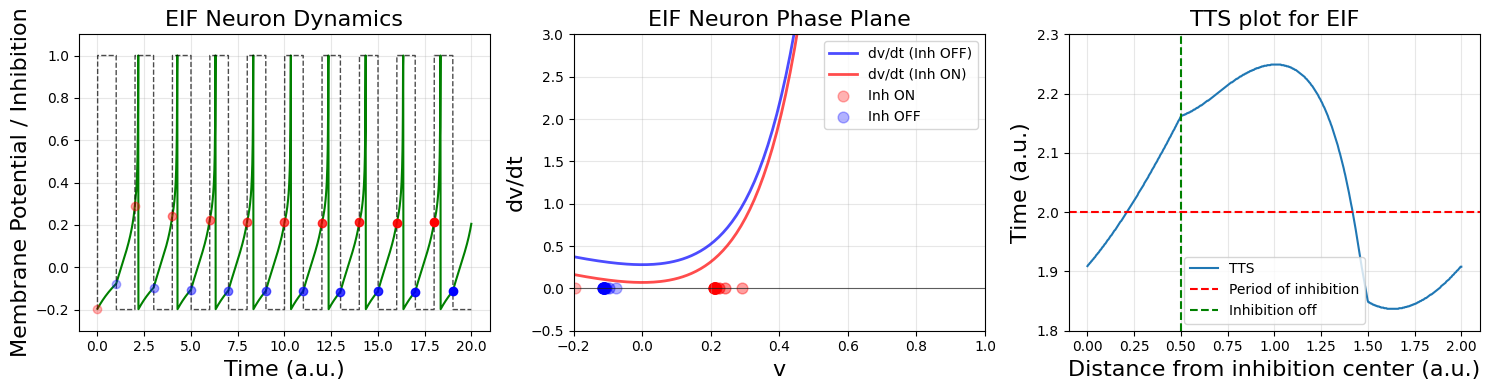

In [15]:
# ============================================================================
# Parameters from the paper (Section 3.5)
# ============================================================================
delta_T = 0.14  # mV, slope factor
V_T = 0.0       # mV, threshold potential for exponential term
I_ext = 0.14    # pA, external current
a_inh = 0.21    # pA, inhibitory current amplitude
V_th = 1.0      # mV, firing threshold
V_reset = -0.2  # mV, reset potential
T_period = 2.0  # ms, period of inhibition

# ============================================================================
# Panel A: EIF Neuron Dynamics (Membrane Potential Time Series)
# ============================================================================
def plot_panel_a(ax, I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset, 
                 dt=0.01, T_sim=20):
    """
    Simulate and plot EIF neuron membrane potential with periodic inhibition.
    Red dots: voltage when inhibition turns ON
    Blue dots: voltage when inhibition turns OFF
    """
    time = np.arange(0, T_sim, dt)
    inh = a_inh * (np.sin(2 * np.pi * time / T_period) > 0).astype(float)

    V = V_reset
    V_trace = np.zeros_like(time)

    # Simulate EIF neuron
    for t in range(len(time)):
        # EIF dynamics: dV/dt = -V + I + ΔT*exp((V-VT)/ΔT) - inh
        exp_term = delta_T * np.exp((V - V_T) / delta_T)
        dV = (-V + I_ext + exp_term - inh[t]) * dt
        V += dV
        if V >= V_th:
            V_trace[t] = V_th
            V = V_reset
        else:
            V_trace[t] = V

    # Detect inhibition transitions
    inh_diff = np.diff(inh)
    inh_on_indices = np.where(inh_diff > 0)[0]
    inh_off_indices = np.where(inh_diff < 0)[0]

    # Create transparency gradients
    alphas_on = np.linspace(0.3, 1, len(inh_on_indices))
    alphas_off = np.linspace(0.3, 1, len(inh_off_indices))

    # Plot
    ax.plot(time, V_trace, 'g-', linewidth=1.5, label='Membrane Potential')

    # Plot inhibition (rescaled for visibility)
    rescaled_inh = (inh / a_inh) * (V_th - V_reset) + V_reset
    ax.plot(time, rescaled_inh, 'k--', linewidth=1, alpha=0.7)

    # Mark voltages at inhibition transitions
    for i, idx in enumerate(inh_on_indices):
        ax.plot(time[idx], V_trace[idx], 'ro', markersize=6, alpha=alphas_on[i])

    for i, idx in enumerate(inh_off_indices):
        ax.plot(time[idx], V_trace[idx], 'bo', markersize=6, alpha=alphas_off[i])

    ax.set_xlabel('Time (a.u.)', fontsize=16)
    ax.set_ylabel('Membrane Potential / Inhibition', fontsize=16)
    ax.set_title('EIF Neuron Dynamics', fontsize=16)
    ax.set_ylim([V_reset - 0.1, V_th + 0.1])
    ax.grid(True, alpha=0.3)

# ============================================================================
# Panel B: Phase Plane (dV/dt vs V)
# ============================================================================
def plot_panel_b(ax, I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset,
                 dt=0.01, T_sim=20):
    """
    Plot phase plane showing nullclines and trajectory points at transitions.
    """
    # Simulate to get trajectory
    time = np.arange(0, T_sim, dt)
    inh = a_inh * (np.sin(2 * np.pi * time / T_period) > 0).astype(float)

    V = V_reset
    V_trace = np.zeros_like(time)

    for t in range(len(time)):
        exp_term = delta_T * np.exp((V - V_T) / delta_T)
        dV = (-V + I_ext + exp_term - inh[t]) * dt
        V += dV
        if V >= V_th:
            V_trace[t] = V_th
            V = V_reset
        else:
            V_trace[t] = V

    # Plot nullclines
    V_range = np.linspace(V_reset - 0.1, V_th, 200)

    # dV/dt when inhibition is OFF (blue)
    exp_term_off = delta_T * np.exp((V_range - V_T) / delta_T)
    dVdt_off = -V_range + I_ext + exp_term_off
    ax.plot(V_range, dVdt_off, 'b-', linewidth=2, label='dv/dt (Inh OFF)', alpha=0.7)

    # dV/dt when inhibition is ON (red)
    dVdt_on = -V_range + I_ext + exp_term_off - a_inh
    ax.plot(V_range, dVdt_on, 'r-', linewidth=2, label='dv/dt (Inh ON)', alpha=0.7)

    # Detect inhibition transitions (match QIF/LIF styling)
    inh_diff = np.diff(inh)
    inh_on_indices = np.where(inh_diff > 0)[0]
    inh_off_indices = np.where(inh_diff < 0)[0]

    # Create transparency gradients
    alphas_on = np.linspace(0.3, 1, len(inh_on_indices)) if len(inh_on_indices) else []
    alphas_off = np.linspace(0.3, 1, len(inh_off_indices)) if len(inh_off_indices) else []

    # Plot markers at dv/dt = 0 just like the LIF/QIF phase planes
    for i, idx in enumerate(inh_on_indices):
        ax.scatter(V_trace[idx], 0, color='r', s=60, alpha=alphas_on[i], label='Inh ON' if i == 0 else "")

    for i, idx in enumerate(inh_off_indices):
        ax.scatter(V_trace[idx], 0, color='b', s=60, alpha=alphas_off[i], label='Inh OFF' if i == 0 else "")

    ax.axhline(0, color='k', linewidth=0.8, alpha=0.6)
    ax.set_xlabel('v', fontsize=16)
    ax.set_ylabel('dv/dt', fontsize=16)
    ax.set_title('EIF Neuron Phase Plane', fontsize=16)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([V_reset, V_th])
    ax.set_ylim([-0.5, 3])

# ============================================================================
# Panel C: Time-To-Spike (TTS) Function
# ============================================================================
def plot_panel_c(ax, I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset,
                 dt=0.001, T_sim=10):
    """
    Plot time-to-spike (TTS) function.
    X-axis: Distance from inhibition center (t_in)
    Y-axis: Time to spike
    """
    # Array of phase offsets (distance from inhibition center)
    center_array = np.linspace(0, T_period, 500)

    time = np.arange(0, T_sim, dt)
    V_array = V_reset * np.ones(len(center_array))
    V_trace = np.zeros((len(time), len(center_array)))
    active = np.ones(len(center_array), dtype=bool)

    # Simulate multiple neurons with different phase offsets
    for t in range(len(time)):
        # Inhibition depends on phase offset
        # Center of inhibition-on period is at center_array
        inh = a_inh * (np.sin(2 * np.pi * (time[t] - center_array) / T_period + np.pi / 2) > 0)

        # EIF dynamics for all phase offsets simultaneously
        exp_term = delta_T * np.exp((V_array - V_T) / delta_T)
        dV = (-V_array + I_ext + exp_term - inh) * dt
        V_array += dV * active
        V_trace[t, :] = V_array
        spiking = (V_array >= V_th) & active
        V_trace[t, spiking] = V_th
        V_array[spiking] = V_reset
        active &= ~spiking

    # Find first time each neuron crosses threshold
    crossed = V_trace >= V_th
    first_pass = np.argmax(crossed, axis=0)
    spike_times = np.full(len(center_array), np.nan)
    valid = crossed.any(axis=0)
    spike_times[valid] = time[first_pass[valid]]

    # Plot TTS function
    ax.plot(center_array, spike_times, label='TTS')
    ax.axhline(y=T_period, color='red', linestyle='--', linewidth=1.5, 
               label='Period of inhibition')
    ax.axvline(x=T_period / 4, color='green', linestyle='--', linewidth=1.5,
               label='Inhibition off')

    ax.set_xlabel('Distance from inhibition center (a.u.)', fontsize=16)
    ax.set_ylabel('Time (a.u.)', fontsize=16)
    ax.set_title('TTS plot for EIF', fontsize=16)
    ax.set_ylim([1.8, 2.3])  # Adjust based on your data
    ax.legend()
    ax.grid(True, alpha=0.3)

# ============================================================================
# Main: Create Figure 9
# ============================================================================
def create_figure9():
    """
    Create Figure 9 with three panels: A, B, C
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Panel A: Membrane potential dynamics
    plot_panel_a(axs[0], I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset)

    # Panel B: Phase plane
    plot_panel_b(axs[1], I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset)

    # Panel C: TTS function
    plot_panel_c(axs[2], I_ext, a_inh, T_period, delta_T, V_T, V_th, V_reset)

    plt.tight_layout()
    plt.show()

create_figure9()
